### This notebook generates the precipitation efficiency distribution for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

In [3]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_indx = np.argwhere( (minlat_array >= -30) & (maxlat_array <= 30) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]

# applying same for pmax and pacc
pmax_array = nc_open_compile(file_years,"pmax")
pmax_ERAI = negative_to_nan(pmax_array)[tropical_indx]

-56.0
56.0
(695667,)


In [5]:
#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERAI = np.double((xr.open_dataset(file_years[0])).pressure.data)*100

# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
temp_ERAI = nc_open_compile( file_years, "temperature", 'stack' )[tropical_indx]
qvsat_ERAI = eps * satVapP_liq(temp_ERAI) / ( plev_ERAI - satVapP_liq(temp_ERAI) )

(32,)
(695667, 32)


### Precipitation efficiency from integrated condensation rate scaling

In [20]:
# Calculate the gradient with respect to pressure of the saturation vapor mixing ratio
p_ERAI = (xr.open_dataset(file_years[0])).pressure.data*100. # converting hPa -> Pa
dqvsat_dp_ERAI = np.gradient( qvsat_ERAI, p_ERAI, axis=1 )

# Multiply the gradient with respect to pressure by pressure velocity
omega_array = nc_open_compile(file_years,"omega",'stack')
omega_ERAI = positive_to_nan(omega_array)[tropical_indx]
integrand = omega_ERAI * dqvsat_dp_ERAI / g

# Determine integration bounds on the basis of the cold-point tropopause
tempmean_ERAI = np.nanmean( temp_ERAI, axis=0 )
#print(tempmean_ERAI)

# Integrate the condensation rate over the pressures
cond_rate_ERAI = np.trapz( x=p_ERAI[:-1], y=-1.*integrand[:,:-1] )
print( np.nanmin(cond_rate_ERAI), np.nanmedian(cond_rate_ERAI), np.nanmean(cond_rate_ERAI), np.nanmax(cond_rate_ERAI) )
peff_ERAI = pmax_ERAI / 3600 / cond_rate_ERAI
print( np.nanmin(peff_ERAI), np.nanmedian(peff_ERAI), np.nanmax(peff_ERAI) )

-4.397951030464751e-06 0.0002418088658225283 0.0002674998710204207 0.011008421073960389
-221.84872679419473 7.003932908154794 384.8225560481695


In [31]:
print(len(peff_ERAI>0))

695667


In [6]:
# Thermodynamic parameters - how strong is correlation with these?
t2m_array = nc_open_compile(file_years,"t2m")
t2m_ERAI = negative_to_nan(t2m_array)[tropical_indx]
dpt_array = nc_open_compile(file_years,"dpt")
dpt_ERAI = negative_to_nan(dpt_array)[tropical_indx]
sst_array = nc_open_compile(file_years,"sst")
sst_ERAI = negative_to_nan(sst_array)[tropical_indx]

In [7]:
# Storm morphology parameters - how strong is correlation with these?
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERAI = negative_to_nan(ctt_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]

In [26]:
print(t2m_ERAI.shape)

(695667,)


In [8]:
# Integrated amounts of cloud condensate - how strong is correlation with these?
qi_array = nc_open_compile(file_years,"qi","stack")
qi_ERAI = negative_to_nan(qi_array)[tropical_indx]
IWP_ERAI = np.cumsum( rho_water*qi_ERAI, axis=1 )*1000 # [g m-2]
IWP_ERAI = IWP_ERAI[:,-1]
qc_array = nc_open_compile(file_years,"qc","stack")
qc_ERAI = negative_to_nan(qc_array)[tropical_indx]
LWP_ERAI = np.cumsum( rho_water*qc_ERAI, axis=1 )*1000 # [g m-2]
LWP_ERAI = LWP_ERAI[:,-1]

# CAPE and integrated mass flux - how strong is correlation with these?
cape_array = nc_open_compile(file_years,"cape")
cape_ERAI = negative_to_nan(cape_array)[tropical_indx]
capepre_array = nc_open_compile(file_years,"capepre")
capepre_ERAI = negative_to_nan(capepre_array)[tropical_indx]
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERAI = negative_to_nan(capepre6_array)[tropical_indx]
omega_array = nc_open_compile(file_years,"omega","stack")
omega_ERAI = positive_to_nan(omega_array)[tropical_indx]
#omegaint_ERAI = np.cumsum( rho*w_ERAI, axis=1 )*1000 # [g m-2]
#print(omegaint_ERAI.shape)
#omegaint_ERAI = omegaint_ERAI[:,-1]
#print(omegaint_ERAI.shape)

In [25]:
# Filter for the correlations below
cape_ERAI = cape_ERAI[peff_ERAI >= 0]
capepre_ERAI = capepre_ERAI[peff_ERAI >= 0]
capepre6_ERAI = capepre6_ERAI[peff_ERAI >= 0]
rad_ERAI = rad_ERAI[peff_ERAI >= 0]
ctt_ERAI = ctt_ERAI[peff_ERAI >= 0]
maxrad_ERAI = maxrad_ERAI[peff_ERAI >= 0]
minctt_ERAI = minctt_ERAI[peff_ERAI >= 0]
IWP_ERAI_2 = IWP_ERAI[peff_ERAI >= 0]
omega_ERA_2 = omega_ERAI[peff_ERAI>=0,:]
#wint_ERAI = wint_ERAI[peff_ERAI >= 0]
LWP_ERAI_2 = LWP_ERAI[peff_ERAI >= 0]
lifetime_ERAI = lifetime_ERAI[peff_ERAI >= 0]
t2m_ERAI = t2m_ERAI[peff_ERAI >= 0]
dpt_ERAI = dpt_ERAI[peff_ERAI >= 0]
sst_ERAI = sst_ERAI[peff_ERAI >= 0]

pmax_ERAI_2 = pmax_ERAI[peff_ERAI >= 0]
peff_ERAI = peff_ERAI[peff_ERAI >= 0]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 695667 but corresponding boolean dimension is 39381

In [10]:
print('Correlation of precip efficiency with storm morphology parameters')
print( ma.corrcoef(rad_ERAI, peff_ERAI)[0,1] )
print( ma.corrcoef(maxrad_ERAI, peff_ERAI)[0,1] )
print( ma.corrcoef(ctt_ERAI, peff_ERAI)[0,1] )
print( ma.corrcoef(minctt_ERAI, peff_ERAI)[0,1] )
print( ma.corrcoef(lifetime_ERAI, peff_ERAI)[0,1] )
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with LWP versus IWP')
print( np.corrcoef(LWP_ERAI_2[~np.isnan(LWP_ERAI_2)], peff_ERAI[~np.isnan(LWP_ERAI_2)])[0,1] )
print( np.corrcoef(IWP_ERAI_2[~np.isnan(IWP_ERAI_2)], peff_ERAI[~np.isnan(IWP_ERAI_2)])[0,1] )
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with various surface temperatures')
print( np.corrcoef(t2m_ERAI, peff_ERAI)[0,1] )
print( np.corrcoef(sst_ERAI[~np.isnan(sst_ERAI)], peff_ERAI[~np.isnan(sst_ERAI)])[0,1] )
print( np.corrcoef(dpt_ERAI, peff_ERAI)[0,1] )
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with CAPE, integrated mass flux, and w')
print( np.corrcoef(cape_ERAI[~np.isnan(cape_ERAI)], peff_ERAI[~np.isnan(cape_ERAI)])[0,1] )
print( np.corrcoef(capepre_ERAI[~np.isnan(capepre_ERAI)], peff_ERAI[~np.isnan(capepre_ERAI)])[0,1] )
print( np.corrcoef(capepre6_ERAI[~np.isnan(capepre6_ERAI)], peff_ERAI[~np.isnan(capepre6_ERAI)])[0,1] )
#print( np.corrcoef(wint_ERAI, peff_ERAI)[0,1] )
#for i in np.arange(w_ERA_2.shape[1]):
#    print( np.corrcoef(w_ERA_2[:,i], peff_ERAI)[0,1] )

Correlation of precip efficiency with storm morphology parameters
0.1968143373461888
0.06898270584128938
0.050381237784257425
-0.03981219283639907
0.04364222299217337
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with LWP versus IWP
-0.020665901026202766
0.005332425883972671
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with various surface temperatures
-0.020787513017533208
0.01180654966924733
0.06400188672158702
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with CAPE, integrated mass flux, and w
0.02420648209481083
0.01597073434982182
0.01245603866853693


In [22]:
print(IWP_ERAI.shape)

(695667, 32)


In [21]:
IWP_ERAI = IWP_ERAI[:,-1]
print(peff_ERAI.shape,LWP_ERAI_2.shape)

(39381,) (39381,)


In [29]:
print(np.percentile( peff_ERAI, 99.9 ))
print(np.nanmax( peff_ERAI ))
print(np.nanmedian( peff_ERAI))
print(np.nanmean( peff_ERAI))
print(len(peff_ERAI>0))
peff_ERAI = peff_ERAI[peff_ERAI>0]
print(len(peff_ERAI<1))

139.7167666402955
384.8225560481695
7.004138806058911
11.822904042914612
42742
42742


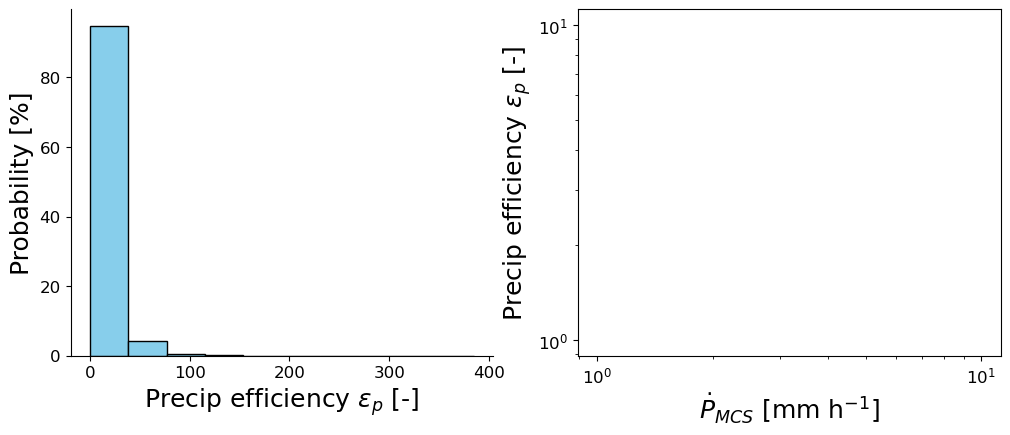

In [25]:
fs = 18
fig, ax = plt.subplots( 1, 2, figsize =(12, 4.5) )

wgts = np.ones_like( peff_ERAI )/float( len( peff_ERAI ) )*100
#bins=np.logspace(-3.5, 0, 35),
ax[0].hist( peff_ERAI, weights=wgts, color='skyblue', edgecolor='black' )
ax[0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[0].set_xlabel( r'Precip efficiency $\varepsilon_p$ [-]', fontsize=fs )
#ax[0].set_xscale( 'log' )
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

#ax[1].hist2d( pmax_ERAI_2, peff_ERAI, bins=[ np.logspace(-1,2,35), np.logspace(-3,0,35) ], cmap=plt.cm.Blues )
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'Precip efficiency $\varepsilon_p$ [-]', fontsize=fs)
ax[1].set_xlabel(r'$\dot{P}_{MCS}$ [mm h$^{-1}$]', fontsize=fs)

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/precipeff-ERAI.pdf', bbox_inches='tight' )
plt.show()

In [42]:
peff_ERAI = peff_ERAI*-1
peff_ERAI = peff_ERAI[peff_ERAI>0]
print(peff_ERAI)

[]
